# Тест работоспособности предобученной RuClip модели 

- ожидаю получить от `get_image_embedding` и `get_text_embedding` numpy.ndarray.shape = (512,)

In [1]:
%%capture
%pip install ruclip==0.0.2
%pip install huggingface-hub==0.23.3 --force-reinstall --no-deps

https://github.com/ai-forever/ru-clip/issues/25

какая-то фигня, потому что через такой инсталл в любом случае подк

In [2]:
import ruclip
from base_clip import BaseClip
import torch
import requests
from io import BytesIO
import numpy as np
from PIL import Image

class RuClip_p32_384(BaseClip):
    MODEL_NAME = "ruclip-vit-base-patch32-384"

    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.processor = ruclip.load(self.MODEL_NAME, device=self.device)

    async def get_image_embedding(self, image: Image.Image) -> np.ndarray:
        image = image.convert("RGB")
        inputs = self.processor(images=[image])
        pixel_values = inputs["pixel_values"].to(self.device)

        with torch.no_grad():
            image_features = self.model.encode_image(pixel_values)
            image_features /= image_features.norm(dim=-1, keepdim=True)

        return image_features.cpu().numpy()[0]

    async def get_text_embedding(self, text: str) -> np.ndarray:
        inputs = self.processor(text=[text])
        input_ids = inputs["input_ids"].to(self.device)

        with torch.no_grad():
            text_features = self.model.encode_text(input_ids)
            text_features /= text_features.norm(dim=-1, keepdim=True)

        return text_features.cpu().numpy()[0]
    
    @property
    def parameters_count(self):
        return sum(p.numel() for p in self.model.parameters())


clip = RuClip_p32_384()

c:\Users\bezgr\STUDY\HSE\Course 2\Smart-Gallery\ml_api\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\bezgr\STUDY\HSE\Course 2\Smart-Gallery\ml_api\.venv\Lib\site-packages\huggingface_hub\file_download.py:671: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'


In [3]:
text = 'notebook'
text_emb = await clip.get_text_embedding(text)
print(text_emb.shape)
text

(512,)


'notebook'

(512,)


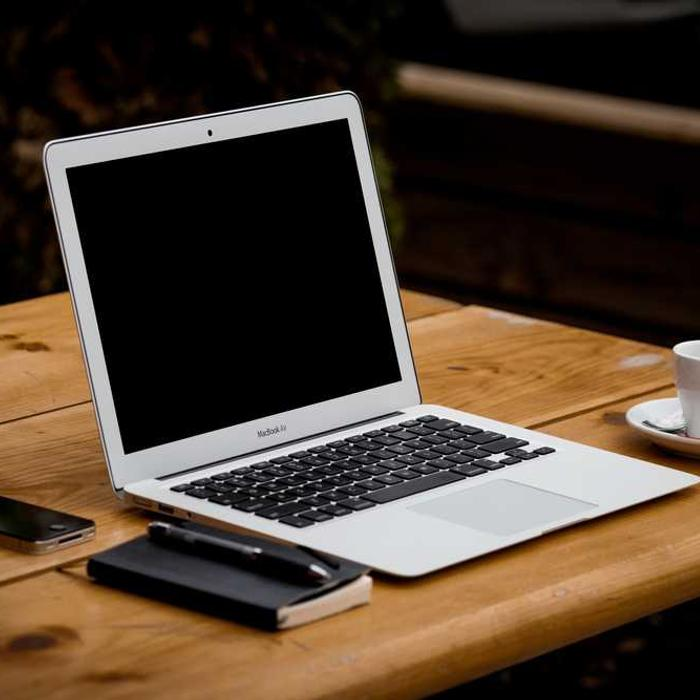

In [4]:
image_url = "https://fastly.picsum.photos/id/0/700/700.jpg?hmac=TYp6WZXT6ArnxZAGMgLiC6IlVpgmVkqAgoAo9aZCfm4"
image = Image.open(BytesIO(requests.get(image_url).content))
image_emb = await clip.get_image_embedding(image)
print(image_emb.shape)
image

In [5]:
def cosine_distance(embedding1, embedding2):
    return np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))


cosine_distance(image_emb, text_emb)

np.float32(0.24695782)